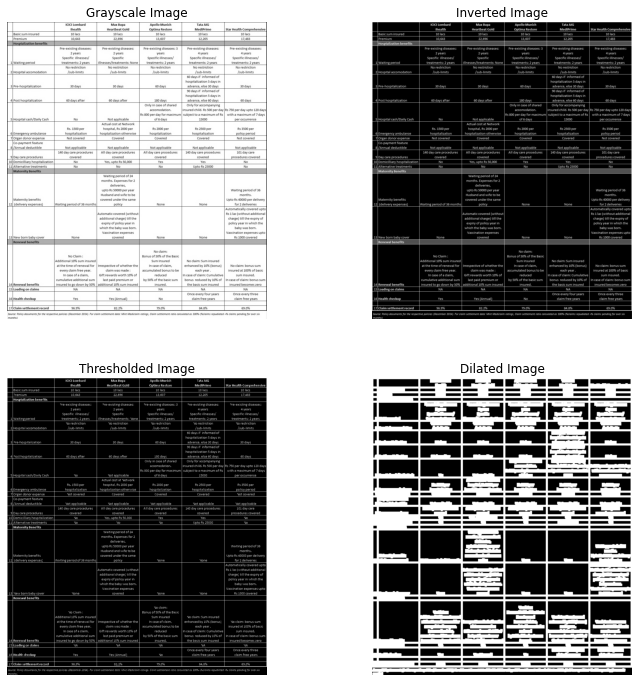

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path=r'C:\Users\Subhadeep\Downloads\mns_images\Sample MNS Bartrack Report-1.png'
# Load the image
image = cv2.imread(image_path)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Invert the grayscale image
inverted = cv2.bitwise_not(gray)

# Apply thresholding to get a binary image
_, thresh = cv2.threshold(inverted, 150, 255, cv2.THRESH_BINARY)

# Dilate the image to make lines thicker
kernel = np.ones((5,5), np.uint8)
dilated = cv2.dilate(thresh, kernel, iterations=2)


# Display the images using Matplotlib
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Grayscale Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(cv2.cvtColor(inverted, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title('Inverted Image')
axes[0, 1].axis('off')

axes[1, 0].imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title('Thresholded Image')
axes[1, 0].axis('off')

axes[1, 1].imshow(cv2.cvtColor(dilated, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title('Dilated Image')
axes[1, 1].axis('off')

plt.show()


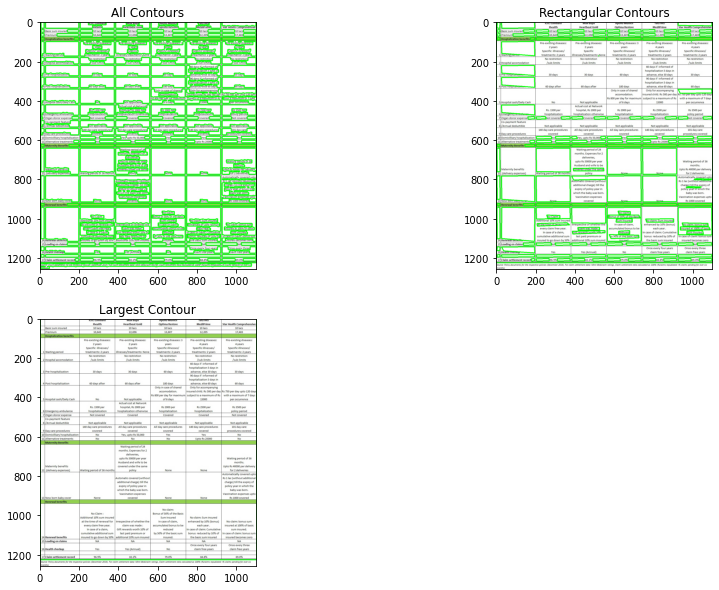

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class ContourFinder:
    def __init__(self, image_path):
        self.image = cv2.imread(image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        self.inverted = cv2.bitwise_not(self.gray)
        _, self.binary = cv2.threshold(self.inverted, 150, 255, cv2.THRESH_BINARY)
        kernel = np.ones((5,5), np.uint8)
        self.dilated_image = cv2.dilate(self.binary, kernel, iterations=2)
        self.contours = None
        self.hierarchy = None
        self.rectangular_contours = None
        self.contour_with_max_area = None
        self.image_with_all_contours = None
        self.image_with_only_rectangular_contours = None
        self.image_with_contour_with_max_area = None
        
    def find_contours(self):
        self.contours, self.hierarchy = cv2.findContours(self.dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        self.image_with_all_contours = self.image.copy()
        cv2.drawContours(self.image_with_all_contours, self.contours, -1, (0, 255, 0), 3)

    def filter_contours_and_leave_only_rectangles(self):
        self.rectangular_contours = []
        for contour in self.contours:
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
            if len(approx) == 4:
                self.rectangular_contours.append(approx)
        self.image_with_only_rectangular_contours = self.image.copy()
        cv2.drawContours(self.image_with_only_rectangular_contours, self.rectangular_contours, -1, (0, 255, 0), 3)

    def find_largest_contour_by_area(self):
        max_area = 0
        self.contour_with_max_area = None
        for contour in self.rectangular_contours:
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                self.contour_with_max_area = contour
        self.image_with_contour_with_max_area = self.image.copy()
        cv2.drawContours(self.image_with_contour_with_max_area, [self.contour_with_max_area], -1, (0, 255, 0), 3)
        
    def order_points_in_the_contour_with_max_area(self):
        self.contour_with_max_area_ordered = self.order_points(self.contour_with_max_area)
        self.image_with_points_plotted = self.image.copy()
        for point in self.contour_with_max_area_ordered:
            point_coordinates = (int(point[0]), int(point[1]))
            self.image_with_points_plotted = cv2.circle(self.image_with_points_plotted, point_coordinates, 10, (0, 0, 255), -1)

    def calculate_new_width_and_height_of_image(self):
        existing_image_width = self.image.shape[1]
        existing_image_width_reduced_by_10_percent = int(existing_image_width * 0.9)
        distance_between_top_left_and_top_right = self.calculateDistanceBetween2Points(self.contour_with_max_area_ordered[0], self.contour_with_max_area_ordered[1])
        distance_between_top_left_and_bottom_left = self.calculateDistanceBetween2Points(self.contour_with_max_area_ordered[0], self.contour_with_max_area_ordered[3])
        aspect_ratio = distance_between_top_left_and_bottom_left / distance_between_top_left_and_top_right
        self.new_image_width = existing_image_width_reduced_by_10_percent
        self.new_image_height = int(self.new_image_width * aspect_ratio)

    def apply_perspective_transform(self):
        pts1 = np.float32(self.contour_with_max_area_ordered)
        pts2 = np.float32([[0, 0], [self.new_image_width, 0], [self.new_image_width, self.new_image_height], [0, self.new_image_height]])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        self.perspective_corrected_image = cv2.warpPerspective(self.image, matrix, (self.new_image_width, self.new_image_height))

    def calculateDistanceBetween2Points(self, p1, p2):
        dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
        return dis

    def order_points(self, pts):
        pts = pts.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect
    
    def add_10_percent_padding(self):
        image_height = self.perspective_corrected_image.shape[0]
        padding = int(image_height * 0.1)
        self.perspective_corrected_image_with_padding = cv2.copyMakeBorder(self.perspective_corrected_image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])

# Instantiate the class
contour_finder = ContourFinder(image_path)

# Call the methods
contour_finder.find_contours()
contour_finder.filter_contours_and_leave_only_rectangles()
contour_finder.find_largest_contour_by_area()

# Display the images
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(contour_finder.image_with_all_contours, cv2.COLOR_BGR2RGB))
plt.title('All Contours')
plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(contour_finder.image_with_only_rectangular_contours, cv2.COLOR_BGR2RGB))
plt.title('Rectangular Contours')
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(contour_finder.image_with_contour_with_max_area, cv2.COLOR_BGR2RGB))
plt.title('Largest Contour')
plt.show()



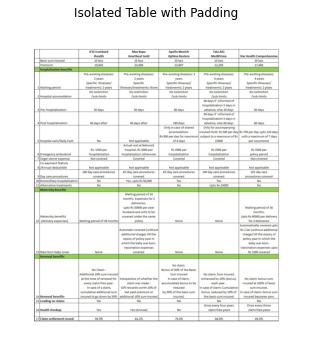

In [3]:
contour_finder.order_points_in_the_contour_with_max_area()
contour_finder.calculate_new_width_and_height_of_image()
contour_finder.apply_perspective_transform()
contour_finder.add_10_percent_padding()

# Display the isolated part of the image with padding
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(contour_finder.perspective_corrected_image_with_padding, cv2.COLOR_BGR2RGB))
plt.title('Isolated Table with Padding')
plt.axis('off')
plt.show()

### Removing Lines

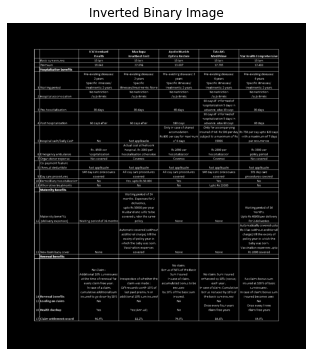

In [4]:
class LineRemover:
    def __init__(self, image_with_padding_path):
        self.image_with_padding = image_with_padding_path
        self.grey = None
        self.thresholded_image = None
        self.inverted_image = None

    def grayscale_image(self):
        self.grey = cv2.cvtColor(self.image_with_padding, cv2.COLOR_BGR2GRAY)

    def threshold_image(self):
        self.thresholded_image = cv2.threshold(self.grey, 127, 255, cv2.THRESH_BINARY)[1]

    def invert_image(self):
        self.inverted_image = cv2.bitwise_not(self.thresholded_image)

    def display_image(self):
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(self.inverted_image, cv2.COLOR_BGR2RGB))
        plt.title('Inverted Binary Image')
        plt.axis('off')
        plt.show()
        
    def erode_vertical_lines(self):
        hor = np.array([[1,1,1,1,1,1]])
        self.vertical_lines_eroded_image = cv2.erode(self.inverted_image, hor, iterations=10)
        self.vertical_lines_eroded_image = cv2.dilate(self.vertical_lines_eroded_image, hor, iterations=10)

    def display_image_with_eroded_vertical_lines(self):
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(self.vertical_lines_eroded_image, cv2.COLOR_BGR2RGB))
        plt.title('Image with Vertical Lines Eroded')
        plt.axis('off')
        plt.show()
        
    def erode_horizontal_lines(self):
        ver = np.array([[1], [1], [1], [1], [1], [1], [1]])
        self.horizontal_lines_eroded_image = cv2.erode(self.inverted_image, ver, iterations=10)
        self.horizontal_lines_eroded_image = cv2.dilate(self.horizontal_lines_eroded_image, ver, iterations=10)
        
    def display_image_with_eroded_horizontal_lines(self, image):
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(self.horizontal_lines_eroded_image, cv2.COLOR_BGR2RGB))
        plt.title('Image with horizontal Lines Eroded')
        plt.axis('off')
        plt.show()
        
    def combine_eroded_images(self):
        self.combined_image = cv2.add(self.vertical_lines_eroded_image, self.horizontal_lines_eroded_image)

    def display_image_with_combined_lines(self, image):
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(self.combined_image, cv2.COLOR_BGR2RGB))
        plt.title('Image with combined eroded lines')
        plt.axis('off')
        plt.show()
    def dilate_combined_image_to_make_lines_thicker(self):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        self.combined_image_dilated = cv2.dilate(self.combined_image, kernel, iterations=5)

    def display_thickened_lines(self):
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(self.combined_image_dilated, cv2.COLOR_BGR2RGB))
        plt.title('Image with Thickened Lines')
        plt.axis('off')
        plt.show()
        
    def subtract_combined_and_dilated_image_from_original_image(self):
        self.image_without_lines = cv2.subtract(self.inverted_image, self.combined_image_dilated)
        
    def display_image_without_lines(self, image):
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(self.image_without_lines, cv2.COLOR_BGR2RGB))
        plt.title('Image without Lines')
        plt.axis('off')
        plt.show()
    def remove_noise_with_erode_and_dilate(self):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        self.image_without_lines_noise_removed = cv2.erode(self.image_without_lines, kernel, iterations=1)
        self.image_without_lines_noise_removed = cv2.dilate(self.image_without_lines_noise_removed, kernel, iterations=1)
        
    def display_image_without_noise(self, image):
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(self.image_without_lines_noise_removed, cv2.COLOR_BGR2RGB))
        plt.title('Image without noise')
        plt.axis('off')
        plt.show()


# Instantiate the class
line_remover = LineRemover(contour_finder.perspective_corrected_image_with_padding)

# Call the preprocessing methods
line_remover.grayscale_image()
line_remover.threshold_image()
line_remover.invert_image()

# Display the inverted binary image
line_remover.display_image()

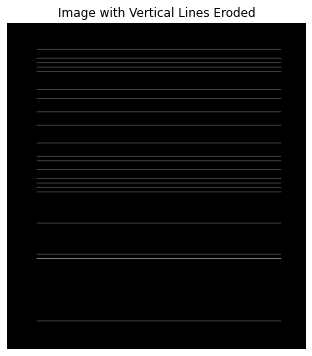

In [5]:
# Instantiate the class
line_remover = LineRemover(contour_finder.perspective_corrected_image_with_padding)

# Call the preprocessing methods
line_remover.grayscale_image()
line_remover.threshold_image()
line_remover.invert_image()
line_remover.erode_vertical_lines()

# Display the image with eroded vertical lines
line_remover.display_image_with_eroded_vertical_lines()

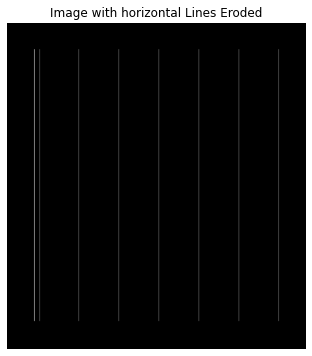

In [6]:
# Instantiate the class
line_remover = LineRemover(contour_finder.perspective_corrected_image_with_padding)

# Call the preprocessing methods
line_remover.grayscale_image()
line_remover.threshold_image()
line_remover.invert_image()
line_remover.erode_vertical_lines()
line_remover.erode_horizontal_lines()

# Display the image with eroded horizontal lines
line_remover.display_image_with_eroded_horizontal_lines(line_remover.horizontal_lines_eroded_image)

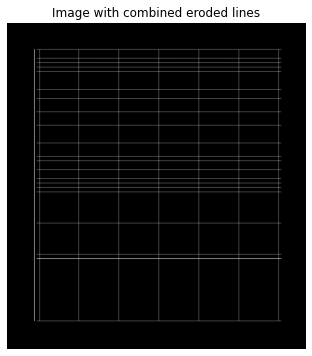

In [7]:
# Instantiate the class
line_remover = LineRemover(contour_finder.perspective_corrected_image_with_padding)

# Call the preprocessing methods
line_remover.grayscale_image()
line_remover.threshold_image()
line_remover.invert_image()
line_remover.erode_vertical_lines()
line_remover.erode_horizontal_lines()
line_remover.combine_eroded_images()

# Display the image with combined eroded lines
line_remover.display_image_with_combined_lines(line_remover.combined_image)

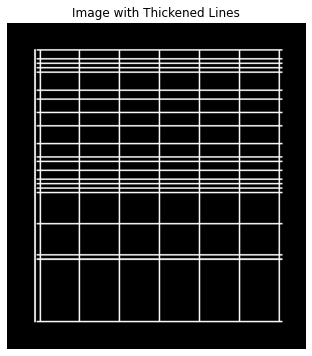

In [8]:
# Instantiate the class
line_remover = LineRemover(contour_finder.perspective_corrected_image_with_padding)

# Call the preprocessing methods
line_remover.grayscale_image()
line_remover.threshold_image()
line_remover.invert_image()
line_remover.erode_vertical_lines()
line_remover.erode_horizontal_lines()
line_remover.combine_eroded_images()
line_remover.dilate_combined_image_to_make_lines_thicker()

# Display the image with thickened lines
line_remover.display_thickened_lines()

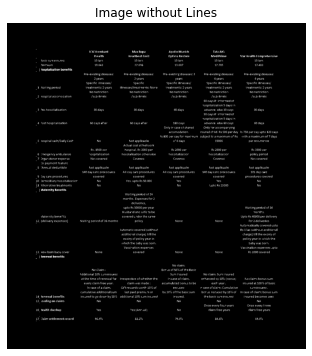

In [11]:
# Instantiate the class
line_remover = LineRemover(contour_finder.perspective_corrected_image_with_padding)

# Call the preprocessing methods
line_remover.grayscale_image()
line_remover.threshold_image()
line_remover.invert_image()
line_remover.erode_vertical_lines()
line_remover.erode_horizontal_lines()
line_remover.combine_eroded_images()
line_remover.dilate_combined_image_to_make_lines_thicker()
line_remover.subtract_combined_and_dilated_image_from_original_image()

# Display the image without lines
line_remover.display_image_without_lines(line_remover.image_without_lines)

### Converting text to blobs

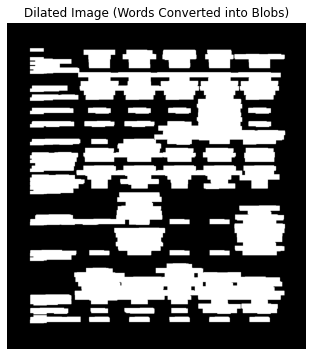

In [12]:
class BlobConverter:
    def __init__(self, image_without_lines_noise_removed):
        self.image_without_lines_noise_removed = image_without_lines_noise_removed
        self.original_image_with_padding = contour_finder.perspective_corrected_image_with_padding
        self.thresholded_image = None
        self.dilated_image = None
        self.contours = None
        self.bounding_boxes = None
        self.image_with_contours_drawn = None
        self.image_with_all_bounding_boxes = None

    def dilate_image(self):
        kernel_to_remove_gaps_between_words = np.array([
            [1,1,1,1,1,1,1,1,1,1],
            [1,1,1,1,1,1,1,1,1,1]
        ])
        self.dilated_image = cv2.dilate(self.image_without_lines_noise_removed, kernel_to_remove_gaps_between_words, iterations=5)
        simple_kernel = np.ones((5,5), np.uint8)
        self.dilated_image = cv2.dilate(self.dilated_image, simple_kernel, iterations=1)

    def display_image(self):
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(self.dilated_image, cv2.COLOR_BGR2RGB))
        plt.title('Dilated Image (Words Converted into Blobs)')
        plt.axis('off')
        plt.show()
        
    def find_contours(self):
        result = cv2.findContours(self.dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        self.contours = result[0]
        self.image_with_contours_drawn = self.original_image_with_padding.copy()
        cv2.drawContours(self.image_with_contours_drawn, self.contours, -1, (0, 255, 0), 3)

    def convert_contours_to_bounding_boxes(self):
        self.bounding_boxes = []
        self.image_with_all_bounding_boxes = self.original_image_with_padding.copy()
        for contour in self.contours:
            x, y, w, h = cv2.boundingRect(contour)
            self.bounding_boxes.append((x, y, w, h))
            self.image_with_all_bounding_boxes = cv2.rectangle(self.image_with_all_bounding_boxes, (x, y), (x + w, y + h), (0, 255, 0), 5)

    def display_image_with_bounding_boxes(self):
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(self.image_with_all_bounding_boxes, cv2.COLOR_BGR2RGB))
        plt.title('Original Image with Bounding Boxes')
        plt.axis('off')
        plt.show()

# Instantiate the class
blob_converter = BlobConverter(line_remover.image_without_lines )

# Call the method to dilate the image
blob_converter.dilate_image()

# Display the dilated image
blob_converter.display_image()

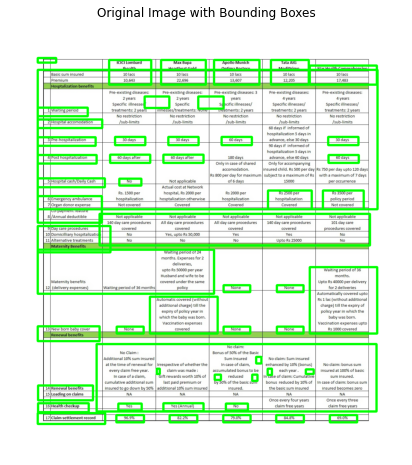

In [14]:
class BlobConverter:
    def __init__(self, image_without_lines_noise_removed, original_image_with_padding):
        self.image_without_lines_noise_removed = image_without_lines_noise_removed
        self.original_image_with_padding = original_image_with_padding
        self.thresholded_image = None
        self.dilated_image = None
        self.contours = None
        self.bounding_boxes = None
        self.image_with_contours_drawn = None
        self.image_with_all_bounding_boxes = None

    def dilate_image(self):
        kernel_to_remove_gaps_between_words = np.array([
            [1,1,1,1,1,1,1,1,1,1],
            [1,1,1,1,1,1,1,1,1,1]
        ])
        self.dilated_image = cv2.dilate(self.image_without_lines_noise_removed, kernel_to_remove_gaps_between_words, iterations=5)
        simple_kernel = np.ones((5,5), np.uint8)
        self.dilated_image = cv2.dilate(self.dilated_image, simple_kernel, iterations=2)

    def find_contours(self):
        result = cv2.findContours(self.dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        self.contours = result[0]
        self.image_with_contours_drawn = self.original_image_with_padding.copy()
        cv2.drawContours(self.image_with_contours_drawn, self.contours, -1, (0, 255, 0), 3)

    def convert_contours_to_bounding_boxes(self):
        self.bounding_boxes = []
        self.image_with_all_bounding_boxes = self.original_image_with_padding.copy()
        for contour in self.contours:
            x, y, w, h = cv2.boundingRect(contour)
            self.bounding_boxes.append((x, y, w, h))
            self.image_with_all_bounding_boxes = cv2.rectangle(self.image_with_all_bounding_boxes, (x, y), (x + w, y + h), (0, 255, 0), 5)

    def display_image_with_bounding_boxes(self):
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(self.image_with_all_bounding_boxes, cv2.COLOR_BGR2RGB))
        plt.title('Original Image with Bounding Boxes')
        plt.axis('off')
        plt.show()

# Instantiate the class
blob_converter = BlobConverter(line_remover.image_without_lines, contour_finder.perspective_corrected_image_with_padding)

# Call the methods
blob_converter.dilate_image()
blob_converter.find_contours()
blob_converter.convert_contours_to_bounding_boxes()

# Display the original isolated image with padding with bounding boxes
blob_converter.display_image_with_bounding_boxes()

### Saving the boxes

In [15]:
import os

class TextExtractor:
    def __init__(self, original_image_with_padding, bounding_boxes):
        self.original_image_with_padding = original_image_with_padding
        self.bounding_boxes = bounding_boxes
        self.mean_height = None
        self.rows = None
        self.table = None
        self.output_directory = "./cropped_images_MNS"  # Directory to save cropped images

        # Create the output directory if it doesn't exist
        os.makedirs(self.output_directory, exist_ok=True)

    def get_mean_height_of_bounding_boxes(self):
        heights = [bounding_box[3] for bounding_box in self.bounding_boxes]
        self.mean_height = np.mean(heights)

    def sort_bounding_boxes_by_y_coordinate(self):
        self.bounding_boxes = sorted(self.bounding_boxes, key=lambda x: x[1])

    def club_all_bounding_boxes_by_similar_y_coordinates_into_rows(self):
        self.rows = []
        half_of_mean_height = self.mean_height / 2
        current_row = [self.bounding_boxes[0]]
        for bounding_box in self.bounding_boxes[1:]:
            current_bounding_box_y = bounding_box[1]
            previous_bounding_box_y = current_row[-1][1]
            distance_between_bounding_boxes = abs(current_bounding_box_y - previous_bounding_box_y)
            if distance_between_bounding_boxes <= half_of_mean_height:
                current_row.append(bounding_box)
            else:
                self.rows.append(current_row)
                current_row = [bounding_box]
        self.rows.append(current_row)

    def sort_all_rows_by_x_coordinate(self):
        for row in self.rows:
            row.sort(key=lambda x: x[0])

    def crop_each_bounding_box_and_ocr(self):
        self.table = []
        current_row = []
        image_number = 0
        for row in self.rows:
            for bounding_box in row:
                x, y, w, h = bounding_box
                y = max(y - 5, 0)
                cropped_image = self.original_image_with_padding[y:y+h, x:x+w]
                image_slice_path = f"./ocr_slices/img_{image_number}.jpg"
                cv2.imwrite(image_slice_path, cropped_image)
                results_from_ocr = self.get_result_from_tesseract(image_slice_path)
                current_row.append(results_from_ocr)
                image_number += 1
            self.table.append(current_row)
            current_row = []


    def crop_each_bounding_box_and_save(self):
        for i, row in enumerate(self.rows):
            for j, bounding_box in enumerate(row):
                x, y, w, h = bounding_box
                y = max(y - 5, 0)
                cropped_image = self.original_image_with_padding[y:y+h, x:x+w]
                image_name = f"image_{i}_{j}.jpg"
                image_path = os.path.join(self.output_directory, image_name)
                cv2.imwrite(image_path, cropped_image)

# Instantiate the class
text_extractor = TextExtractor(contour_finder.perspective_corrected_image_with_padding, blob_converter.bounding_boxes)

# Call the methods
text_extractor.get_mean_height_of_bounding_boxes()
text_extractor.sort_bounding_boxes_by_y_coordinate()
text_extractor.club_all_bounding_boxes_by_similar_y_coordinates_into_rows()
text_extractor.sort_all_rows_by_x_coordinate()
text_extractor.crop_each_bounding_box_and_save()
